In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import math
import statsmodels.api as sm
import warnings
from IPython.core.interactiveshell import InteractiveShell
from scipy import stats
import multiprocessing as mp
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
import tensorflow as tf, keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model, Sequential

mp.set_start_method("fork")


InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

In [2]:
# Load the .npz file
data = np.load('data.npz')

# Access X and y from the loaded data
X = data['X']
y = data['y']

In [3]:
#Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

y_train = y_train[:, 0, :]

### Attempt 1: Entire Play (NOT FRAME BY FRAME)

In [7]:
#Define the Input Shape (127 frames, 22 players, 32 field of data)
input_shape = (127, 22, 32)
num_players = 22

model = Sequential([
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.3),
    Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.4),
    Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_players, activation='softmax')
])

#Compile the model
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#Summarize the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 127, 22, 128)      36992     
                                                                 
 batch_normalization_8 (Batc  (None, 127, 22, 128)     512       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 127, 22, 128)      147584    
                                                                 
 batch_normalization_9 (Batc  (None, 127, 22, 128)     512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 11, 128)      0         
 2D)                                                             
                                                      

In [8]:
#Fit the Model
history = model.fit(X_train, y_train,
                    epochs = 50,
                    validation_split = 0.2,
                    batch_size = 32,
                    callbacks=[keras.callbacks.ModelCheckpoint("CNN_model_1.h5",save_best_only=True,save_weights_only=False),
                               keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/50


2023-11-01 14:43:36.620235: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-01 14:43:36.987694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


201/201 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.0484

2023-11-01 14:44:03.364962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


201/201 [==============================] - 29s 134ms/step - loss: 0.4411 - accuracy: 0.0484 - val_loss: 0.5765 - val_accuracy: 0.0292
Epoch 2/50
201/201 [==============================] - 25s 123ms/step - loss: 0.2916 - accuracy: 0.0504 - val_loss: 0.7019 - val_accuracy: 0.0529
Epoch 3/50
201/201 [==============================] - 25s 124ms/step - loss: 0.2736 - accuracy: 0.0537 - val_loss: 0.4601 - val_accuracy: 0.0516
Epoch 4/50
201/201 [==============================] - 25s 123ms/step - loss: 0.2600 - accuracy: 0.0694 - val_loss: 0.4349 - val_accuracy: 0.0622
Epoch 5/50
201/201 [==============================] - 25s 124ms/step - loss: 0.2495 - accuracy: 0.0837 - val_loss: 0.2848 - val_accuracy: 0.0952
Epoch 6/50
201/201 [==============================] - 25s 122ms/step - loss: 0.2448 - accuracy: 0.1063 - val_loss: 0.3074 - val_accuracy: 0.1176
Epoch 7/50
201/201 [==============================] - 25s 122ms/step - loss: 0.2339 - accuracy: 0.1525 - val_loss: 0.3655 - val_accuracy: 0.1

### Creating New Test Data:

In [524]:
#Testing Model
#Read-In Data
df = pd.read_csv('20231031_AllGames_wAdvancedTracking.csv')

In [525]:
#Drop Columns that Can Lead to Memorizaton
df = df.drop(columns = ['gameId','playId','event','tackle_x','tackle_y','playTime'])

#One-Hot Encode "Position" Variable
df = df.join(pd.get_dummies(df['position'], dtype=float))
df = df.drop(columns = ['position'])

#Replacing playerType with defense
df.loc[(df.playerType != 'Offense')&(df.playerType != 'ballCarrier'), 'playerType'] = 'Defense'

#One-Hot Encode "playerType" Variable
df = df.join(pd.get_dummies(df['playerType'], dtype=float))
df = df.drop(columns = ['playerType'])

In [526]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

##Normalize the Data (MINMAX)
columns_to_normalize = ['x', 'y', 's', 'a', 'dis', 'o', 'dir','distance_to_ballCarrier']
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

##Normalize the Data (STANDARD)
columns_to_normalize = ['age', 'height','weight']
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [527]:
df = df[['key', 'nflId', 'frameId', 'tackle', 'x', 'y', 's', 'a', 'dis', 'o', 'dir',
       'height', 'weight', 'age', 'distance_to_ballCarrier', 'C', 'CB',
       'DB', 'DE', 'DT', 'FB', 'FS', 'G', 'ILB', 'MLB', 'NT', 'OLB', 'QB',
       'RB', 'SS', 'T', 'TE', 'WR', 'Defense', 'Offense', 'ballCarrier']]

In [528]:
max_frames = 127
#Number of Players per Frame
num_players = 22

#Empty arrays for Input Data (X) and target data (y)
X_test = []
y_test = []

play_data = df[df.key == int(df.key.sample())]
    
#List of Frames for this Key
frames = np.zeros((max_frames, 22, 32))
tackle_labels = np.zeros((max_frames, 22))
play_data = play_data.sort_values(by = ['frameId', 'nflId']).reset_index(drop = True)

for frame in play_data['frameId'].unique():
    frame_data_acc = []
    tackle_label_acc = []

    frame_data_rows = play_data[play_data['frameId'] == frame]
    
    for _, row in frame_data_rows.iterrows():
        frame_data = row.iloc[4:].values
        frame_data_acc.append(frame_data)
        tackle_label_acc.append(row['tackle'])

    frame_data = np.stack(frame_data_acc, axis = 0)
    tackle_label = np.array(tackle_label_acc)
    
    frames[frame - 1] = frame_data
    tackle_labels[frame - 1] = tackle_label


    X_test.append(frames)
    y_test.append(tackle_labels)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test[0:1]
y_test = y_test[0:1]

X_test.shape
y_test.shape

(1, 127, 22, 32)

(1, 127, 22)

### Predicting Test Data

In [529]:
predictions = model.predict(X_test).round(2)
predictions
np.where(predictions == predictions.max())
print('---------------------')
np.where(y_test[0][0].round(3) == 1)

1/1 [==============================] - 0s 54ms/step


array([[0.  , 0.  , 0.  , 0.98, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

(array([0]), array([3]))

---------------------


(array([3]),)

In [530]:
predictions = []
for i in range(play_data['frameId'].max()):
    incoming = np.zeros((1, 127, 22, 32))
    incoming[0][:i] = X_test[0][:i]

    pred = model.predict(incoming, verbose = 0)
    predictions.append(pred)

In [531]:
flat_list = []
for sublist in predictions:
    for item in sublist:
        for value in item:
            flat_list.append(value)

play_data['Predictions'] = flat_list

### Anmiate Predictions

In [532]:
#Read in Data
df = pd.read_csv('20231031_AllGames_wAdvancedTracking.csv')
df = df[df.nflId.notna()]

In [533]:
games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
plays = pd.read_csv('plays.csv')
tackles = pd.read_csv('tackles.csv')


def playAnimator(data, GAMEID, PLAYID):

    colors = [[0, 'lime'],
              [0.01, 'gray'],
              [0.02, 'black'],
              [0.2, 'red'],
              [0.4, 'orange'],
              [0.6, 'gold'],
              [0.8, 'yellow'],
              [1, 'white']]
    
    cmap = LinearSegmentedColormap.from_list('', colors)
    
    play_data = plays[(plays.gameId == GAMEID)&(plays.playId == PLAYID)]
    
    fig = fig = px.scatter(data, x = 'x', y = 'y', range_x = [0,120], range_y = [0, 53.3],
              color = 'Predictions', animation_frame = 'frameId', width=1000, height=565,
                          range_color = [0, 1], color_continuous_scale = colors)
    
    fig = fig.add_vrect(x0=0, x1=10, fillcolor = 'gray')
    fig = fig.add_vrect(x0=110, x1=120, fillcolor = 'gray')
    fig = fig.add_vline(x = int(play_data['absoluteYardlineNumber']), line_dash="dash", 
                        line_color="blue", opacity = 0.5)
    # fig = fig.add_vline(x = int(play_data['absoluteYardlineNumber']) - int(play_data['yardsToGo']),
    #                     line_dash="dash", line_color="gold", opacity = 0.5)
    fig = fig.update_layout(
        plot_bgcolor='#567D46'
    )
    fig = fig.update_yaxes(visible=False)
    fig = fig.update_layout(xaxis=dict(
        tick0=0,
        dtick=10,))
    
    fig = fig.update_traces(marker=dict(size=12,line=dict(width=2,color='black'), opacity=0.9),
                      selector=dict(mode='markers'))
    
    # Set frame duration to 100ms
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 130
    
    # Set transition xduration between frames to 0ms
    fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0
    
    return fig

In [534]:
str(play_data.key.unique())[1:11]
str(play_data.key.unique())[-5:-1]

'2022102308'

'1137'

In [535]:
animate = df[(df.gameId == 2022102308)&(df.playId == 1137)]
animate.loc[(animate.playerType != 'Offense')&(animate.playerType != 'ballCarrier'), 'playerType'] = 'Defense'
tackle_prob = play_data[['nflId','frameId','Predictions']]
animate = pd.merge(animate, tackle_prob, on = ['nflId','frameId'])
animate = animate.drop(columns = ['distance_to_ballCarrier'])
animate.loc[(animate.playerType == 'Defense') & (animate.Predictions <= 0.02), 'Predictions'] =  0.02
animate.loc[(animate.playerType == 'Offense'), 'Predictions']  = 0.01
animate.loc[(animate.playerType == 'ballCarrier'), 'Predictions'] = 0

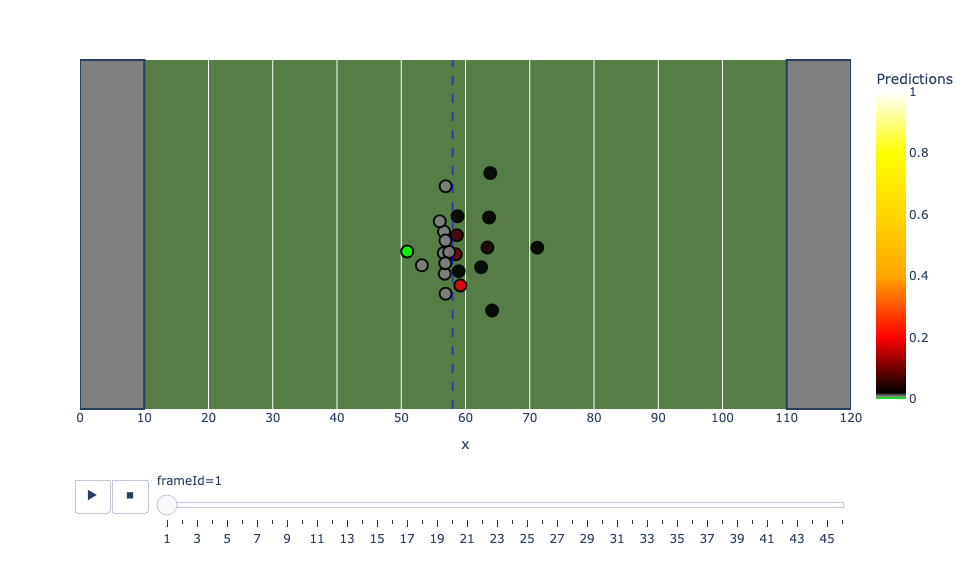

In [536]:
playAnimator(animate, 2022102308, 1137)